# Fine-tuning and Evaluation of Language Models

Install necessary libraries 

In [ ]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 878.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 7.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

Import relevant libraries

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback, set_seed
from sklearn.metrics import classification_report
import datasets
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc("font", size=25)

ModuleNotFoundError: ignored

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Parameters

 one has to consider before training a transformer model including:
- The learning rate (LR) which indicates how fast the model's weights are going to be updated (larger values results in faster training)
- The number of epochs (EPOCHS) indicating how many times the model will go through the train data (1 epoch means that the model will see the train set only once).
- The batch size (BATCH_SIZE) indicating the number of samples that will be pass through to the model at one time.

There many other hyper-parameters that you can experiment with such as `weight_decay` and `warmup_ratio` (find more at: https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/trainer#transformers.TrainingArguments) and feel free to experiment with them but depending on your understanding of the models used it may be best to use the default values provided.

In [ ]:
LR = 1e-5
EPOCHS = 6
BATCH_SIZE = 24
MODEL = "cardiffnlp/twitter-roberta-base" # use this to finetune the language model
#MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest" # use this to finetune the sentiment classifier
MAX_TRAINING_EXAMPLES = 7500 # set this to -1 if you want to use the whole training set


As the models are non-deterministic (i.e. can produce different results even if trained on the same dataset) we can set a seed so we can reproduce our experiments. In this notebook we are going to use the seed 223.

In [ ]:
# set transformers seed
seed = 223
set_seed(seed)

# Data
We will be utilizing the the sentiment dataset for the TweetEval benchmark however feel free to use your own dataset if you prefer!

## Option 1: Download the dataset from CardiffNLP's github.


Loading TweetEval dataset for the sentiment task.
Also available tasks for: 
- Emoji Prediction (emoji)
- Emotion Recognition (emotion)
- Hate Speech Detection (hate)
- Irony Detection (irony)
- Offensive Language Identification (offensive)
- Stance Detection (stance)

See: https://github.com/cardiffnlp/tweeteval/tree/main/datasets for more details


In [ ]:
task = "sentiment"

files = """test_labels.txt
test_text.txt
train_labels.txt
train_text.txt
val_labels.txt
val_text.txt""".split('\n')

for f in files:
  p = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/{f}"
  !wget $p


--2022-06-30 15:33:03--  https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_labels.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24568 (24K) [text/plain]
Saving to: ‘test_labels.txt’

test_labels.txt     100%[===================>]  23.99K  --.-KB/s    in 0s      

2022-06-30 15:33:03 (120 MB/s) - ‘test_labels.txt’ saved [24568/24568]

--2022-06-30 15:33:03--  https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_text.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

We now read the data from the files we donwloaded, format the data in a more usable structure and create the train, validation, and test sets  i.e. ``` { 'train': { 'text': ['foobar', ...], 'labels': [0, ...] }, ... } ```.


In [ ]:
dataset_dict = {}
for i in ['train','val','test']:
  dataset_dict[i] = {}
  for j in ['text','labels']:
    dataset_dict[i][j] = open(f"{i}_{j}.txt").read().split('\n')[:-1] # ignore last line of file
    if j == 'labels':
      dataset_dict[i][j] = [int(x) for x in dataset_dict[i][j]]

if MAX_TRAINING_EXAMPLES > 0:
  dataset_dict['train']['text']=dataset_dict['train']['text'][:MAX_TRAINING_EXAMPLES]
  dataset_dict['train']['labels']=dataset_dict['train']['labels'][:MAX_TRAINING_EXAMPLES]

  

In [ ]:
# Transform dictionaries to datasets.Dataset for easier preprocessing (https://huggingface.co/docs/datasets/v1.11.0/loading_datasets.html#from-a-python-dictionary)
train_dataset = datasets.Dataset.from_dict(dataset_dict['train'])
val_dataset = datasets.Dataset.from_dict(dataset_dict['val'])
test_dataset = datasets.Dataset.from_dict(dataset_dict['test'])

Initialize and use model's tokenizer to get the text encodings.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], truncation=True), batched=True)
val_dataset = val_dataset.map(lambda e: tokenizer(e['text'], truncation=True), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['text'], truncation=True), batched=True)

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Parameter 'function'=<function <lambda> at 0x7f637fc1e4d0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/46 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

## Option 2: Download the dataset directly from huggingface (https://huggingface.co/datasets/tweet_eval).

In [ ]:
# load dataset using 'datasets' library by specifying the name of the dataset and the subset (task).
#task = 'sentiment'
#dataset = datasets.load_dataset('tweet_eval', task)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
train_raw = pd.read_csv('drive/My Drive/tweets_labelled_09042020_16072020.csv', delimiter=';')

FileNotFoundError: ignored

In [ ]:
train_df = train_raw[train_raw.sentiment.isna() == False].copy()

NameError: ignored

In [ ]:
train_df

NameError: ignored

In [ ]:
# Define a label mapping dictionary
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

# Map the string labels to numerical labels
train_df['sentiment'] = train_df['sentiment'].map(label_map)

In [ ]:
train_df

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",2
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,0
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,2
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,2
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,2
...,...,...,...,...
1295,75519,2020-04-15 06:00:10+00:00,#stocks back from the recovery room: https://t...,2
1296,739234,2020-07-01 11:29:10+00:00,RT @MacroCharts: Breadth – expanding last week...,2
1297,254379,2020-04-29 02:21:50+00:00,RT @MawsonResource: Rompas-Rajapalot: A Big Ne...,1
1298,580441,2020-06-19 17:56:57+00:00,$AAPL $QQQ Top may now be in. https://t.co/iNK...,2


In [ ]:
from datetime import datetime 
import re
from tqdm import tqdm

In [ ]:
def preprocess(text):
    new_text = []
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
#Preprocessing 

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Preprocessing begun.") #Printing start time

tqdm.pandas() #Getting a progress bar. Use progress_apply instead of apply.
train_df['text_preprocess'] = train_df['text'].progress_apply(lambda x: preprocess(x))

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Preprocessing completed.") #Printing end time

2023-03-12 17:08:26 Preprocessing begun.


100%|██████████| 1300/1300 [00:00<00:00, 84863.97it/s]

2023-03-12 17:08:26 Preprocessing completed.


In [ ]:
train_df

,id,created_at,text,sentiment,text_preprocess
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",2,"RT @user Yo💥\nEnter to WIN 1,000 Monarch Token..."
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,0,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,2,Net issuance increases to fund fiscal programs...
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,2,RT @user How much of Amazon's traffic is serve...
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,2,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...
...,...,...,...,...,...
1295,75519,2020-04-15 06:00:10+00:00,#stocks back from the recovery room: https://t...,2,#stocks back from the recovery room: http \n\n...
1296,739234,2020-07-01 11:29:10+00:00,RT @MacroCharts: Breadth – expanding last week...,2,RT @user Breadth – expanding last week's discu...
1297,254379,2020-04-29 02:21:50+00:00,RT @MawsonResource: Rompas-Rajapalot: A Big Ne...,1,RT @user Rompas-Rajapalot: A Big New Camp. Raj...
1298,580441,2020-06-19 17:56:57+00:00,$AAPL $QQQ Top may now be in. https://t.co/iNK...,2,$AAPL $QQQ Top may now be in. http


In [ ]:
train_df = train_df.rename(columns={'text': 'raw_text', 'text_preprocess': 'text', 'sentiment':'label'})


In [ ]:
new_df = train_df[['text', 'label']]

In [ ]:
new_df

,text,label
0,"RT @user Yo💥\nEnter to WIN 1,000 Monarch Token...",2
1,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,0
2,Net issuance increases to fund fiscal programs...,2
3,RT @user How much of Amazon's traffic is serve...,2
4,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,2
...,...,...
1295,#stocks back from the recovery room: http \n\n...,2
1296,RT @user Breadth – expanding last week's discu...,2
1297,RT @user Rompas-Rajapalot: A Big New Camp. Raj...,1
1298,$AAPL $QQQ Top may now be in. http,2


In [ ]:
# # use model's tokenizer to get text encodings
# tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

# dataset = new_df.map(lambda e: tokenizer(e['text'], truncation=True))

# # make sure to use whole train dataset if MAX_TRAINING_EXAMPLES == -1
# if MAX_TRAINING_EXAMPLES == -1: MAX_TRAINING_EXAMPLES = dataset['train'].shape[0]
# # split into train/val/test sets
# train_dataset = dataset['train'].select(range(MAX_TRAINING_EXAMPLES))
# val_dataset = dataset['validation']
# test_dataset = dataset['test']

In [ ]:
# use model's tokenizer to get text encodings
#tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)
#MAX_LEN = 256

In [ ]:
# class SentimentData(Dataset):
#     def __init__(self, dataframe, tokenizer, max_len):
#         self.tokenizer = tokenizer
#         self.data = dataframe
#         self.text = dataframe.text
#         self.targets = self.data.label
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.text)

#     def __getitem__(self, index):
#         text = str(self.text[index])
#         text = " ".join(text.split())

#         inputs = self.tokenizer.encode_plus(
#             text,
#             None,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             truncation=True,
#             padding='max_length',
#             return_token_type_ids=True
#         )
#         ids = inputs['input_ids']
#         mask = inputs['attention_mask']
#         token_type_ids = inputs["token_type_ids"]


#         return {
#             'ids': torch.tensor(ids, dtype=torch.long),
#             'mask': torch.tensor(mask, dtype=torch.long),
#             'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
#             'targets': torch.tensor(self.targets[index], dtype=torch.float)
#         }

In [ ]:
# use model's tokenizer to get text encodings
#tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

# create a new column in the DataFrame to store the tokenized text
#new_df['encoded_text'] = new_df['text'].apply(lambda x: tokenizer.encode(x, max_length=256, truncation=True))

In [ ]:

# split the DataFrame into train and test sets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(new_df, test_size=0.2, random_state=seed)

# split the training set into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=seed)

In [ ]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
train_df

,text,label
0,RT @user #BreakingNews\nIsraeli Hospital to Be...,1
1,RT @user Take a Peek of the Week Ahead! http \...,1
2,Kind of cool to have one full share of Honda' ...,2
3,UnitedHealth Group $UNH Price Target Raised to...,2
4,$FRKN #Frencken Group Ltd Frencken Group - Res...,2
...,...,...
775,RT @user Intel Has Been Reiterated As A Top Pi...,2
776,S&amp;P 500 | $SPX | $SPX500 $USD\n\nSPX CORRE...,1
777,RT @user COVID-19 VACCINE FROM PFIZER AND BION...,2
778,$BA $EADSY - Qatar Airways Threatens Boeing An...,0


In [ ]:
# create dataset objects from the DataFrames
train_dict = {'text': list(train_df['text']), 'label': list(train_df['label'])}
val_dict = {'text': list(val_df['text']), 'label': list(val_df['label'])}
test_dict = {'text': list(test_df['text']), 'label': list(test_df['label'])}

In [ ]:
# Transform dictionaries to datasets.Dataset for easier preprocessing (https://huggingface.co/docs/datasets/v1.11.0/loading_datasets.html#from-a-python-dictionary)
train_dataset = datasets.Dataset.from_dict(train_dict)
val_dataset = datasets.Dataset.from_dict(val_dict)
test_dataset = datasets.Dataset.from_dict(test_dict)

In [ ]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 780
})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], max_length=256, truncation=True), batched=True)
val_dataset = val_dataset.map(lambda e: tokenizer(e['text'], max_length=256, truncation=True), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['text'], max_length=256, truncation=True), batched=True)

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 780
})

In [ ]:
# training_set = SentimentData(train_df, tokenizer, MAX_LEN)
# val_set = SentimentData(val_df, tokenizer, MAX_LEN)
# testing_set = SentimentData(test_df, tokenizer, MAX_LEN)

In [ ]:
# training_loader = DataLoader(training_set)

In [ ]:
    # for _,data in tqdm(enumerate(training_loader, 0)):
    #     ids = data['ids'].to(device, dtype = torch.long)
    #     mask = data['mask'].to(device, dtype = torch.long)

In [ ]:
# ids

In [ ]:
# # create dataset objects from the DataFrames
# train_dataset = {'input_ids': list(train_df['encoded_text']), 'labels': list(train_df['label'])}
# val_dataset = {'input_ids': list(val_df['encoded_text']), 'labels': list(val_df['label'])}
# test_dataset = {'input_ids': list(test_df['encoded_text']), 'labels': list(test_df['label'])}

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

# Fine-tuning

The steps above prepared the datasets in the way that the trainer is expected. Now all we need to do is create a model
to fine-tune, define the `TrainingArguments`/`TFTrainingArguments` and
instantiate a `Trainer`/`TFTrainer`.

More information about the Trainer's arguments can be be found here: https://huggingface.co/docs/transformers/v4.20.0/en/main_classes/trainer#transformers.TrainingArguments

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',                   # output directory
    num_train_epochs=EPOCHS,                  # total number of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=100,                          # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                        # strength of weight decay
    logging_dir='./logs',                     # directory for storing logs
    logging_steps=160,                         # when to print log
    evaluation_strategy='steps',              # evaluate every n number of steps. 
    eval_steps=160,                            # how often to evaluate. If not set defaults to number of logging_steps
    load_best_model_at_end=True,              # to load or not the best model at the end
    save_steps=160,                            # create a checkpoint every time we evaluate,
    seed=seed                                 # seed for consistent results

)


num_labels = len(set(train_dataset['labels'])) if 'labels' in train_dataset.features.keys() else len(set(train_dataset['label']))

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=num_labels)
model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
trainer = Trainer(
    model=model,                              # the instantiated 🤗 Transformers model to be trained
    tokenizer=tokenizer,                      # tokenizer to be used to pad the inputs 
    args=training_args,                       # training arguments, defined above
    train_dataset=train_dataset,              # training dataset
    eval_dataset=val_dataset,                  # evaluation dataset
    callbacks = [EarlyStoppingCallback(3, 0.001)], # early stopping which stops the training after 3 evaluation calls with no improvement of performance of at least 0.001
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 780
  Num Epochs = 6
  Instantaneous batch size per device = 24
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 1
  Total optimization steps = 198
  Number of trainable parameters = 124647939
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using 

Step,Training Loss,Validation Loss
160,0.719900,1.025908


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 260
  Batch size = 24
Saving model checkpoint to ./results/checkpoint-160
Configuration saved in ./results/checkpoint-160/config.json
Model weights saved in ./results/checkpoint-160/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-160/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-160/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-160 (score: 1.0259082317352295).


TrainOutput(global_step=198, training_loss=0.603296930139715, metrics={'train_runtime': 97.0485, 'train_samples_per_second': 48.223, 'train_steps_per_second': 2.04, 'total_flos': 267327343558800.0, 'train_loss': 0.603296930139715, 'epoch': 6.0})

Tip: In cases where you are facing memory issue during training try a smaller batch size.

In [ ]:
trainer.save_model("drive/My Drive/thesis/best_model") # save best model

Saving model checkpoint to drive/My Drive/thesis/best_model
Configuration saved in drive/My Drive/thesis/best_model/config.json
Model weights saved in drive/My Drive/thesis/best_model/pytorch_model.bin
tokenizer config file saved in drive/My Drive/thesis/best_model/tokenizer_config.json
Special tokens file saved in drive/My Drive/thesis/best_model/special_tokens_map.json


# Evaluate on Test set

In [ ]:
# for every prediction the model ouptuts logits where largest value indicates the predicted class 
test_preds_raw, test_labels , _ = trainer.predict(test_dataset)
test_preds = np.argmax(test_preds_raw, axis=-1)
print(classification_report(test_labels, test_preds, digits=3))

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 260
  Batch size = 24


              precision    recall  f1-score   support

           0      0.770     0.734     0.752        64
           1      0.689     0.820     0.749        89
           2      0.806     0.701     0.750       107

    accuracy                          0.750       260
   macro avg      0.755     0.752     0.750       260
weighted avg      0.757     0.750     0.750       260



We can also check how "sure" the model is for every prediction by getting the softmax scores for each prediction.

In [ ]:
from scipy.special import softmax

scores = softmax(test_preds_raw, axis=1)
scores

array([[0.75091535, 0.21717778, 0.03190675],
       [0.03866366, 0.783222  , 0.17811418],
       [0.14549494, 0.7729395 , 0.08156547],
       ...,
       [0.5818169 , 0.35726607, 0.06091703],
       [0.7219079 , 0.21501365, 0.06307841],
       [0.03623401, 0.09098262, 0.87278336]], dtype=float32)

# Make predictions on unseen tweets

We are going to apply the model we trained on tweets made by the Prime Ministers of UK (Boris Johnson) and Australia (Anthony Albanese) and their respective oppossition leaders (Keir Starmer & Scott Morrison). Tweets were extracted from January 1 2022 to June 19 2022.

You can find more details on how to extract tweets using the Twiiter api in this notebook: https://colab.research.google.com/drive/1RyiRY3aCUQ_K-PiXp1qN-8l7479uQa9f.

In [ ]:
model_loaded = AutoModelForSequenceClassification.from_pretrained("drive/My Drive/thesis/best_model")

loading configuration file drive/My Drive/thesis/best_model/config.json
Model config RobertaConfig {
  "_name_or_path": "drive/My Drive/thesis/best_model",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("drive/My Drive/thesis/best_model")

loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


In [ ]:
def get_predictions(tweets):
  """ wrapper function to predict sentiment of tweets"""
  with torch.no_grad():
    encoded_input = tokenizer(
        tweets, padding=True, truncation=True, return_tensors='pt'
    )

    # set model on evaluation mode to deactivate Dropout
    model_loaded.eval()
    # pass encoded text to model
    output = model_loaded(**{k: v.to('cuda') for k, v in encoded_input.items()})
    # get logits and move them to cpu to get the predictions
    output = output.logits.detach().cpu().numpy()
    predictions = np.argmax(output, axis=1)

  return predictions[0]

In [ ]:
#Preprocessing 

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Preprocessing begun.") #Printing start time

tqdm.pandas() #Getting a progress bar. Use progress_apply instead of apply.
new_df['prediction'] = new_df['text'].progress_apply(lambda x: get_predictions(x))

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Preprocessing completed.") #Printing end time

2023-03-12 17:54:50 Preprocessing begun.


100%|██████████| 1300/1300 [00:29<00:00, 43.72it/s]

2023-03-12 17:55:20 Preprocessing completed.


In [ ]:
new_df[new_df.label == new_df.prediction]

,text,label,prediction
1,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,0,0
4,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,2,2
5,RT @user Reduce your portfolio RISK! GOLD is a...,2,2
7,RT @user #Apple has cut the prices of the iPho...,0,0
9,Where to Look for Dependable Dividends\nRead M...,1,1
...,...,...,...
1293,RT @user #DayTrading #livestream\nLive Benzing...,1,1
1294,"$UNH - UnitedHealth beats EPS consensus, reite...",1,1
1295,#stocks back from the recovery room: http \n\n...,2,2
1298,$AAPL $QQQ Top may now be in. http,2,2


In [ ]:
device

'cuda'

In [ ]:
test_preds

array([2, 2, 1, 0, 0, 1, 1, 0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 0, 0, 1, 2, 0, 2, 2, 2, 0, 0,
       2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 2, 2, 2, 2, 0,
       2, 2, 1, 0, 1, 2, 0, 1, 0, 1, 2, 1, 0, 2, 0, 0, 1, 1, 1, 2, 0, 2,
       2, 1, 2, 2, 1, 1, 1, 0, 1, 2, 1, 2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 0,
       2, 0, 2, 2, 1, 1, 0, 2, 0, 1, 2, 0, 0, 2, 1, 1, 2, 2, 1, 0, 1, 0,
       2, 1, 2, 1, 1, 2, 1, 0, 1, 2, 0, 2, 1, 2, 0, 0, 2, 2, 2, 1, 0, 2,
       2, 0, 1, 2, 0, 0, 2, 2, 1, 0, 0, 2, 2, 1, 1, 1, 2, 2, 0, 2, 0, 0,
       2, 1, 0, 2, 2, 2, 0, 1, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 1, 2, 1, 2,
       1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1,
       1, 2, 2, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 0, 0, 1, 2, 2, 1,
       2, 0, 1, 1, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 0, 0, 2, 1])

In [ ]:
test_df2 = test_df.copy()

In [ ]:
test_df2['prediction before save'] = test_preds

In [ ]:
test_df2

,text,label,prediction before save
0,"“Gratitude leads to optimism, and a positive a...",2,2
1,RT @user Today’s profit $656 $spy $spx $tsla ...,2,2
2,$SPX $SPY $NDX $DIA $QQQ \n$WYNN ...\nNew... V...,1,1
3,Keep an eye on the 10 year #yield Down over 7%...,0,0
4,RT @user Chart Of The Day: ISE Equity Call/Put...,0,0
...,...,...,...
255,Proud owner of $AMZN stock. This thing might h...,2,2
256,$VZ $ZM $SPY $DIA \nhttps://t.co/MWvubLuMMT\n\...,2,0
257,Short Interest in Chromadex Corp $CDXC Drops B...,0,0
258,RT @user Thanks.\nWith #Ford downgraded to jun...,0,2


In [ ]:
new_df[new_df.text.str.contains('Mercantile Asset Management') == True]

,text,label,prediction
254,River &amp; Mercantile Asset Management Has $1...,2,1


In [ ]:
df_tweet = pd.read_csv('drive/My Drive/thesis/df_AAPL_FINAL_DATASET.csv')

In [ ]:
df_tweet

,Unnamed: 0,Unnamed: 0.1,id,date,content,unique_cashtags,text_preprocess,text_lemma,merge_text_preprocess,merge_text_lemma,text_preprocess_no_tokens
0,0,2,1.608976e+18,2022-12-30 23:57:54+00:00,And yes $aapl will do very well after they sla...,1,and yes $ aapl will do very well after they sl...,and yes $ aapl will do very well after they sl...,and yes $aapl will do very well after they sla...,and yes $aapl will do very well after they sla...,and yes $aapl will do very well after they sla...
1,1,21,1.608973e+18,2022-12-30 23:49:04+00:00,Apple adds iOS 16.2 Home architecture update t...,1,apple adds ios 16.2 home architecture update t...,apple add io 16.2 home architecture update to ...,apple adds ios 16.2 home architecture update t...,apple add io 16.2 home architecture update to ...,apple adds ios 16.2 home architecture update t...
2,2,39,1.608972e+18,2022-12-30 23:41:33+00:00,APPLE 'DEATH CROSS' CONFIRMED ON HOURLY $AAPL,1,apple death cross confirmed on hourly $ aapl,apple death cross confirm on hourly $ aapl,apple death cross confirmed on hourly $aapl,apple death cross confirm on hourly $aapl,apple death cross confirmed on hourly $aapl
3,3,40,1.608971e+18,2022-12-30 23:40:47+00:00,Need twitter to understand @apple and $aapl ar...,1,need twitter to understand and $ aapl are not ...,need twitter to understand and $ aapl be not t...,need twitter to understand and $aapl are not t...,need twitter to understand and $aapl be not th...,need twitter to understand and $aapl are not t...
4,4,43,1.608971e+18,2022-12-30 23:40:00+00:00,Gap of Hope \n\nPrice has Escaped Box \nMoment...,1,gap of hope price has escaped box momentum cle...,gap of hope price have escape box momentum cle...,gap of hope price has escaped box momentum cle...,gap of hope price have escape box momentum cle...,gap of hope \n\nprice has escaped box \nmoment...
...,...,...,...,...,...,...,...,...,...,...,...
207964,207964,617143,1.477439e+18,2022-01-02 00:37:17+00:00,"Ticker: $AAPL\nBuy: January 07, 2022 $180.00 C...",1,ticker $ aapl buy january 07 2022 $ 180.00 cal...,ticker $ aapl buy january 07 2022 $ 180.00 cal...,ticker $aapl buy january 07 2022 $180.00 calls...,ticker $aapl buy january 07 2022 $180.00 call ...,ticker $aapl\nbuy january 07 2022 $180.00 call...
207965,207965,617144,1.477437e+18,2022-01-02 00:28:34+00:00,Apple Watch's Life-Saving Potential Highlighte...,1,apple watchs life-saving potential highlighted...,apple watch life-saving potential highlight in...,apple watchs life-saving potential highlighted...,apple watch life-saving potential highlight in...,apple watchs life-saving potential highlighted...
207966,207966,617148,1.477436e+18,2022-01-02 00:24:33+00:00,$AAPL What a strong month to finish 2021. Will...,1,$ aapl what a strong month to finish 2021 . wi...,$ aapl what a strong month to finish 2021 . wi...,$aapl what a strong month to finish 2021 . wil...,$aapl what a strong month to finish 2021 . wil...,$aapl what a strong month to finish 2021. will...
207967,207967,617149,1.477434e+18,2022-01-02 00:18:26+00:00,if you love me can you follow the best man in ...,1,if you love me can you follow the best man in ...,if you love me can you follow the best man in ...,if you love me can you follow the best man in ...,if you love me can you follow the best man in ...,if you love me can you follow the best man in ...


In [ ]:
def preprocess_new(text):
    
    #Lowercasing words
    text = text.lower()
    
    #Removing '&amp' which was found to be common
    text = re.sub(r'&amp','', text)
    
    #Replace other instances of "&" with "and"
    text = re.sub(r'&','and', text)
    
    #Removing mentions 
    #text = re.sub(r'@\w+ ', '', text)


    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        new_text.append(t)
    text = " ".join(new_text)


    
    #Removing 'RT' and 'via'
    text = re.sub(r'(^rt|^via)((?:\b\W*@\w+)+): ', '', text)
    
    #Removing punctuation
    
    #my_punctuation = string.punctuation.replace('#','')
    #my_punctuation = my_punctuation.replace('$','')
    #my_punctuation = my_punctuation.replace('.','')
    #my_punctuation = my_punctuation.replace('%','')
    #my_punctuation = my_punctuation.replace('!','')
    #my_punctuation = my_punctuation.replace('?','')
    #my_punctuation = my_punctuation.replace('-','')
    
    #text = text.translate(str.maketrans('', '', my_punctuation))
    #text = re.sub(r' - ','', text) #removing dash lines bounded by whitespace (and therefore not part of a word)
    #text = re.sub(r'[’“”—,]','',text) #removing punctuation that is not captured by string.punctuation
    
    #Removing odd special characters
    text = re.sub(r"[┻┃━┳┓┏┛┗]","", text)
    text = re.sub(r"\u202F|\u2069|\u200d|\u2066","", text)
    
    #Removing URLs
    text = re.sub(r'http\S+', '', text)
    
    #Removing numbers
    #text = re.sub(r'[0-9]','', text)
    
    #Removing separators and superfluous whitespace
    text = text.strip()
    text = re.sub(r' +',' ',text)
    
    #Removing emoji
    # emoji_pattern = re.compile("["
    #     u"\U0001F600-\U0001F64F"  # emoticons
    #     u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    #     u"\U0001F680-\U0001F6FF"  # transport & map symbols
    #     u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    #     u"\U00002500-\U00002BEF"  # chinese char
    #     u"\U00002702-\U000027B0"
    #     u"\U00002702-\U000027B0"
    #     u"\U000024C2-\U0001F251"
    #     u"\U0001f926-\U0001f937"
    #     u"\U00010000-\U0010ffff"
    #     u"\u2640-\u2642"
    #     u"\u2600-\u2B55"
    #     u"\u200d"
    #     u"\u23cf"
    #     u"\u23e9"
    #     u"\u231a"
    #     u"\ufe0f"  # dingbats
    #     u"\u3030"
    #                        "]+", flags=re.UNICODE)

    # text = emoji_pattern.sub(r'', text)
    
    return text

In [ ]:
#Preprocessing 

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Preprocessing begun.") #Printing start time

tqdm.pandas() #Getting a progress bar. Use progress_apply instead of apply.
df_tweet['text_preprocess_new_withemo'] = df_tweet['content'].progress_apply(lambda x: preprocess_new(x))

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Preprocessing completed.") #Printing end time

2023-03-12 19:43:04 Preprocessing begun.


100%|██████████| 207969/207969 [00:04<00:00, 48921.85it/s]

2023-03-12 19:43:08 Preprocessing completed.


In [ ]:
df_tweet

,Unnamed: 0,Unnamed: 0.1,id,date,content,unique_cashtags,text_preprocess,text_lemma,merge_text_preprocess,merge_text_lemma,text_preprocess_no_tokens,text_preprocess_new_withemo
0,0,2,1.608976e+18,2022-12-30 23:57:54+00:00,And yes $aapl will do very well after they sla...,1,and yes $ aapl will do very well after they sl...,and yes $ aapl will do very well after they sl...,and yes $aapl will do very well after they sla...,and yes $aapl will do very well after they sla...,and yes $aapl will do very well after they sla...,and yes $aapl will do very well after they sla...
1,1,21,1.608973e+18,2022-12-30 23:49:04+00:00,Apple adds iOS 16.2 Home architecture update t...,1,apple adds ios 16.2 home architecture update t...,apple add io 16.2 home architecture update to ...,apple adds ios 16.2 home architecture update t...,apple add io 16.2 home architecture update to ...,apple adds ios 16.2 home architecture update t...,apple adds ios 16.2 home architecture update t...
2,2,39,1.608972e+18,2022-12-30 23:41:33+00:00,APPLE 'DEATH CROSS' CONFIRMED ON HOURLY $AAPL,1,apple death cross confirmed on hourly $ aapl,apple death cross confirm on hourly $ aapl,apple death cross confirmed on hourly $aapl,apple death cross confirm on hourly $aapl,apple death cross confirmed on hourly $aapl,apple 'death cross' confirmed on hourly $aapl
3,3,40,1.608971e+18,2022-12-30 23:40:47+00:00,Need twitter to understand @apple and $aapl ar...,1,need twitter to understand and $ aapl are not ...,need twitter to understand and $ aapl be not t...,need twitter to understand and $aapl are not t...,need twitter to understand and $aapl be not th...,need twitter to understand and $aapl are not t...,need twitter to understand @user and $aapl are...
4,4,43,1.608971e+18,2022-12-30 23:40:00+00:00,Gap of Hope \n\nPrice has Escaped Box \nMoment...,1,gap of hope price has escaped box momentum cle...,gap of hope price have escape box momentum cle...,gap of hope price has escaped box momentum cle...,gap of hope price have escape box momentum cle...,gap of hope \n\nprice has escaped box \nmoment...,gap of hope \n\nprice has escaped box \nmoment...
...,...,...,...,...,...,...,...,...,...,...,...,...
207964,207964,617143,1.477439e+18,2022-01-02 00:37:17+00:00,"Ticker: $AAPL\nBuy: January 07, 2022 $180.00 C...",1,ticker $ aapl buy january 07 2022 $ 180.00 cal...,ticker $ aapl buy january 07 2022 $ 180.00 cal...,ticker $aapl buy january 07 2022 $180.00 calls...,ticker $aapl buy january 07 2022 $180.00 call ...,ticker $aapl\nbuy january 07 2022 $180.00 call...,"ticker: $aapl\nbuy: january 07, 2022 $180.00 c..."
207965,207965,617144,1.477437e+18,2022-01-02 00:28:34+00:00,Apple Watch's Life-Saving Potential Highlighte...,1,apple watchs life-saving potential highlighted...,apple watch life-saving potential highlight in...,apple watchs life-saving potential highlighted...,apple watch life-saving potential highlight in...,apple watchs life-saving potential highlighted...,apple watch's life-saving potential highlighte...
207966,207966,617148,1.477436e+18,2022-01-02 00:24:33+00:00,$AAPL What a strong month to finish 2021. Will...,1,$ aapl what a strong month to finish 2021 . wi...,$ aapl what a strong month to finish 2021 . wi...,$aapl what a strong month to finish 2021 . wil...,$aapl what a strong month to finish 2021 . wil...,$aapl what a strong month to finish 2021. will...,$aapl what a strong month to finish 2021. will...
207967,207967,617149,1.477434e+18,2022-01-02 00:18:26+00:00,if you love me can you follow the best man in ...,1,if you love me can you follow the best man in ...,if you love me can you follow the best man in ...,if you love me can you follow the best man in ...,if you love me can you follow the best man in ...,if you love me can you follow the best man in ...,if you love me can you follow the best man in ...


In [ ]:
#Preprocessing 

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Preprocessing begun.") #Printing start time

tqdm.pandas() #Getting a progress bar. Use progress_apply instead of apply.
df_tweet['sentiment_prediction'] = df_tweet['text_preprocess_new_withemo'].progress_apply(lambda x: get_predictions(x))

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Preprocessing completed.") #Printing end time

2023-03-12 19:45:04 Preprocessing begun.


100%|██████████| 207969/207969 [49:10<00:00, 70.47it/s]

2023-03-12 20:34:15 Preprocessing completed.


In [ ]:
df_tweet

,Unnamed: 0,Unnamed: 0.1,id,date,content,unique_cashtags,text_preprocess,text_lemma,merge_text_preprocess,merge_text_lemma,text_preprocess_no_tokens,text_preprocess_new_withemo,sentiment_prediction
0,0,2,1.608976e+18,2022-12-30 23:57:54+00:00,And yes $aapl will do very well after they sla...,1,and yes $ aapl will do very well after they sl...,and yes $ aapl will do very well after they sl...,and yes $aapl will do very well after they sla...,and yes $aapl will do very well after they sla...,and yes $aapl will do very well after they sla...,and yes $aapl will do very well after they sla...,2
1,1,21,1.608973e+18,2022-12-30 23:49:04+00:00,Apple adds iOS 16.2 Home architecture update t...,1,apple adds ios 16.2 home architecture update t...,apple add io 16.2 home architecture update to ...,apple adds ios 16.2 home architecture update t...,apple add io 16.2 home architecture update to ...,apple adds ios 16.2 home architecture update t...,apple adds ios 16.2 home architecture update t...,0
2,2,39,1.608972e+18,2022-12-30 23:41:33+00:00,APPLE 'DEATH CROSS' CONFIRMED ON HOURLY $AAPL,1,apple death cross confirmed on hourly $ aapl,apple death cross confirm on hourly $ aapl,apple death cross confirmed on hourly $aapl,apple death cross confirm on hourly $aapl,apple death cross confirmed on hourly $aapl,apple 'death cross' confirmed on hourly $aapl,1
3,3,40,1.608971e+18,2022-12-30 23:40:47+00:00,Need twitter to understand @apple and $aapl ar...,1,need twitter to understand and $ aapl are not ...,need twitter to understand and $ aapl be not t...,need twitter to understand and $aapl are not t...,need twitter to understand and $aapl be not th...,need twitter to understand and $aapl are not t...,need twitter to understand @user and $aapl are...,1
4,4,43,1.608971e+18,2022-12-30 23:40:00+00:00,Gap of Hope \n\nPrice has Escaped Box \nMoment...,1,gap of hope price has escaped box momentum cle...,gap of hope price have escape box momentum cle...,gap of hope price has escaped box momentum cle...,gap of hope price have escape box momentum cle...,gap of hope \n\nprice has escaped box \nmoment...,gap of hope \n\nprice has escaped box \nmoment...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
207964,207964,617143,1.477439e+18,2022-01-02 00:37:17+00:00,"Ticker: $AAPL\nBuy: January 07, 2022 $180.00 C...",1,ticker $ aapl buy january 07 2022 $ 180.00 cal...,ticker $ aapl buy january 07 2022 $ 180.00 cal...,ticker $aapl buy january 07 2022 $180.00 calls...,ticker $aapl buy january 07 2022 $180.00 call ...,ticker $aapl\nbuy january 07 2022 $180.00 call...,"ticker: $aapl\nbuy: january 07, 2022 $180.00 c...",2
207965,207965,617144,1.477437e+18,2022-01-02 00:28:34+00:00,Apple Watch's Life-Saving Potential Highlighte...,1,apple watchs life-saving potential highlighted...,apple watch life-saving potential highlight in...,apple watchs life-saving potential highlighted...,apple watch life-saving potential highlight in...,apple watchs life-saving potential highlighted...,apple watch's life-saving potential highlighte...,2
207966,207966,617148,1.477436e+18,2022-01-02 00:24:33+00:00,$AAPL What a strong month to finish 2021. Will...,1,$ aapl what a strong month to finish 2021 . wi...,$ aapl what a strong month to finish 2021 . wi...,$aapl what a strong month to finish 2021 . wil...,$aapl what a strong month to finish 2021 . wil...,$aapl what a strong month to finish 2021. will...,$aapl what a strong month to finish 2021. will...,2
207967,207967,617149,1.477434e+18,2022-01-02 00:18:26+00:00,if you love me can you follow the best man in ...,1,if you love me can you follow the best man in ...,if you love me can you follow the best man in ...,if you love me can you follow the best man in ...,if you love me can you follow the best man in ...,if you love me can you follow the best man in ...,if you love me can you follow the best man in ...,1


In [ ]:
df_tweet.to_csv('drive/My Drive/thesis/AAPL_tweets_with_sentiment.csv')

In [ ]:
df_tweet.sentiment_prediction.value_counts()

2    85868
1    70816
0    51285
Name: sentiment_prediction, dtype: int64

Download and load the dataset in a pandas Dataframe.

In [ ]:
!gdown https://drive.google.com/uc?id=1EN1jGxwprKxvzV2D4ML3dFp1fMlSrXEb

Downloading...
From: https://drive.google.com/uc?id=1EN1jGxwprKxvzV2D4ML3dFp1fMlSrXEb
To: /content/workshop_tweets.json
100% 14.1M/14.1M [00:00<00:00, 105MB/s] 


First we will see how to get predictions using a custom function.

In [ ]:
def get_predictions(tweets):
  """ wrapper function to predict sentiment of tweets"""
  with torch.no_grad():
    encoded_input = tokenizer(
        tweets, padding=True, truncation=True, return_tensors='pt'
    )

    # set model on evaluation mode to deactivate Dropout
    trainer.model.eval()
    # pass encoded text to model
    output = trainer.model(**{k: v.to('cuda') for k, v in encoded_input.items()})
    # get logits and move them to cpu to get the predictions
    output = output.logits.detach().cpu().numpy()
    predictions = np.argmax(output, axis=1)

  return predictions

tweets = ["RT @UKLabour: Britain is facing the biggest rail strike in a generation but @GrantShapps hasn’t spent a single second in talks to avert it…",
          "Good news in today’s jobs stats: the number of employees on payrolls increased again in March.",
          "I'm #live in Gladstone with my Labor team: https://t.co/chWrHtumLc"]

# get predictions
predictions = get_predictions(tweets)
print(predictions)

# map predictions to negative/neutral/positive
sentiment_mapping = {
    0: 'negative',
    1: 'neutral',
    2: 'positive'
}

predictions = [sentiment_mapping[x] for x in predictions]
print(predictions)

[0 2 1]
['negative', 'positive', 'neutral']


Now let's use the whole dataset.

In [ ]:
# read data into a dataframe and only keep the tweet_id (id), text,  author username, and date of tweet (created_at)
df = pd.read_json('workshop_tweets.json', lines=True)
df['username'] = df['author'].apply(lambda x: x['username'])
df = df[['id', 'text', 'username', 'created_at']]

In [ ]:
# convert pandas to huggingface Dataset & tokenize
df = datasets.Dataset.from_pandas(df)
df = df.map(lambda e: tokenizer(e['text'], truncation=True), batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
# make predicitons
output = trainer.predict(df)
predictions = np.argmax(output.predictions, axis=1)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: username, created_at, id, text. If username, created_at, id, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2459
  Batch size = 64


In [ ]:
# recast to pandas for easier visualizations
df = df.to_pandas()
df['sentiment'] = predictions

 We now are going to consider the distribution of tweets according to their sentiment for each country's government-opposition pair

[Text(0, 0, 'Negative'), Text(0, 0, 'Neutral'), Text(0, 0, 'Positive')]

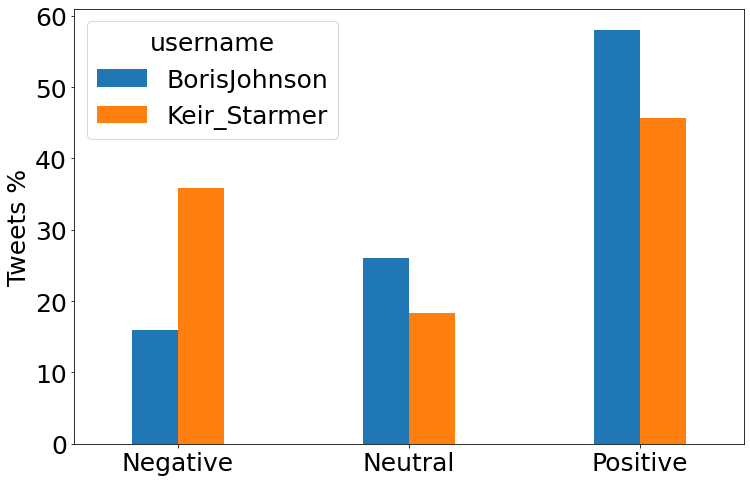

In [ ]:
# consider only UK
df_uk = df[df['username'].isin(['BorisJohnson', 'Keir_Starmer'])]

plot_uk = df_uk.groupby('sentiment')['username'].value_counts()
for idx in plot_uk.index:
    user_count = len(df_uk[df_uk['username'] == idx[1]])
    plot_uk.loc[idx] = (plot_uk.loc[idx]/user_count) * 100

ax = plot_uk.unstack().plot(figsize=(12,8), kind='bar',  xlabel='', legend=True, ylabel='Tweets %',  width=0.4)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'],rotation=0)

[Text(0, 0, 'Negative'), Text(0, 0, 'Neutral'), Text(0, 0, 'Positive')]

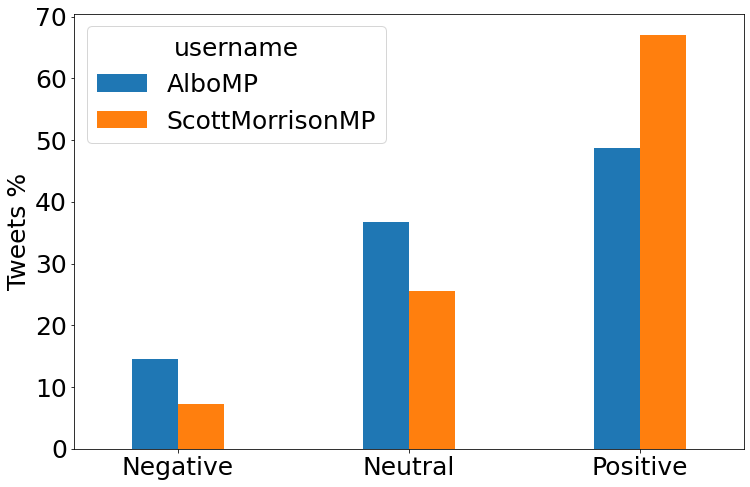

In [ ]:
# consider only Australia
df_aus = df[df['username'].isin(['AlboMP', 'ScottMorrisonMP'])]

plot_aus = df_aus.groupby('sentiment')['username'].value_counts()
for idx in plot_aus.index:
    user_count = len(df_aus[df_aus['username'] == idx[1]])
    plot_aus.loc[idx] = (plot_aus.loc[idx]/user_count) * 100

ax = plot_aus.unstack().plot(figsize=(12,8), kind='bar',  xlabel='', legend=True, ylabel='Tweets %',  width=0.4)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'],rotation=0)

It is important to note that for Australia Anthony Albanese was elected prime minister on May 23 and Scott Morrison previously held that office. It is interesting to explore how their tweets sentiment changes through time.

In [ ]:
df_aus['month'] = df_aus['created_at'].dt.strftime('%m')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


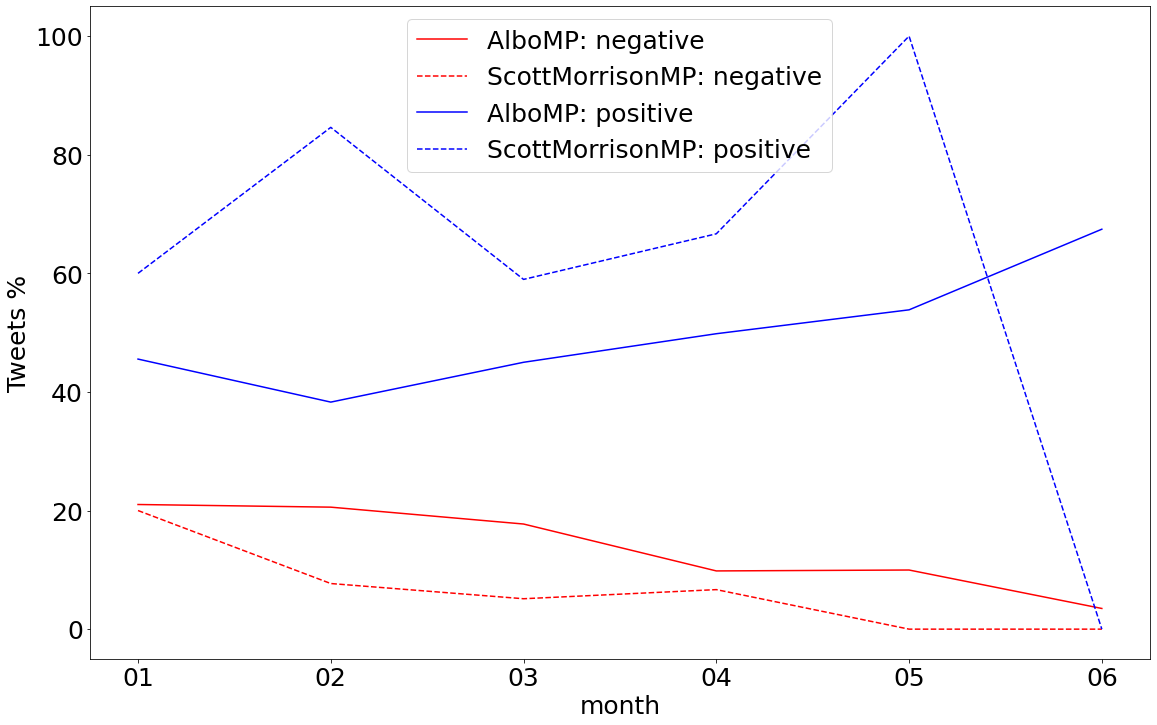

In [ ]:
# Consider only negative and positive sentiments
to_plot = (df_aus.groupby(['month','username'])['sentiment'].value_counts(normalize=True)*100).unstack().unstack().fillna(0)
to_plot[[(0, 'AlboMP'), (0, 'ScottMorrisonMP'), (2, 'AlboMP'), (2, 'ScottMorrisonMP')]].plot(figsize=(19,12), 
                                                                                             color = ['red', 'red', 'blue', 'blue'],
                                                                                             style=['-','--','-','--'],
                                                                                             ylabel='Tweets %')

plt.legend(title='',labels=['AlboMP: negative', 'ScottMorrisonMP: negative', 'AlboMP: positive','ScottMorrisonMP: positive'])